# **<center>Non-Attending Final Project - Luca Masserano, ID: 3017820 </center>**

## **1. Introduction and code setup**

This project is split in two parts: 

- sections 2-4.1 deal with the preprocessing, annotation and analysis of song lyrics, with the final section dedicated to the construction of different models for classification;

- section 4.2 focuses instead on structured prediction of alphabet letters (tags) using rasterized images of handwritten characters.

Throughout the notebook, some cells containing long pieces of code or wrapper classes have been collapsed in order to increase readability.
The following cell contains all the imports for modules that are common to all sections. I will then import specific modules as I go along with the analysis.

In [8]:
import pandas as pd
import numpy as np
import logging
import sys
import re
import time
import tqdm # useful progress bars for iterables
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%run utils.ipynb # some functions used throughout the code for visualizations

## **2. Research question**

Since every step in the analysis, from preprocessing to prediction, has been inspired and guided by the research question, I decided to state it before-hand.

**Being a music lover and passionate piano player, I decided to focus my analysis on song lyrics in order to try to uncover possible patterns in what different artists write and in how they use language to convey messages, taking into consideration different musical genres and time periods. To this end, I divided my research as follows:**

**1. first of all, I tried to bring out some of the inner characteristics of lyrics in terms of most used words and locutions. These were then used to guide the analysis of topics treated, with the aim of discovering if different musical genres have undergone a transformation over the years in the themes they talk about and in how they do so;**

**2. secondly, I wanted to exploit linguistic characteristics of lyrics to build a classifier able to predict the genre of a song given its text.**

## **3. Dataset, Cleaning and Annotation**

### **3.1 Creation of the dataset**

Looking on the internet, I found a few lyrics datasets which someone already constructed for other analysis in the past. Unfortunately, I noticed that all of them had many problems in terms of size, genre misclassification, and wrong lyrics, which would have made the analysis not just very difficult, but also inaccurate.

As a consequence I decided to create my own dataset in two steps: I first downloaded a list of artists, corresponding genres and songs from *MetroLyrics* (https://www.metrolyrics.com). This site allows free unlimited web scraping, and has also an alphabet-ordered directory of artists. For each letter, *MetroLyrics* provides a page of ~50 most popular artists across every musical genre and period, from 50 Cent, Arctic Monkeys and Shakira, to Bruce Springsteen, Billie Holiday and B.B King. Each artist has in turn a whole page of popular songs, usually from ~20 to ~80. 

Once obtained these, I used the wonderful API provided by *Genius* (https://genius.com), a huge database of song lyrics, to obtain the documents for each of the artist-song pairs mentioned above and the corresponding album and release date. 

In [ ]:
import lyricsgenius # Genius API
from textblob import TextBlob # language detector
from bs4 import BeautifulSoup
from selenium import webdriver

# setup basic logging functionality for debugging and to keep track of the retrieval progress
logging.basicConfig(filename="./log_files/lyrics_scraping.log",
                   level=logging.INFO,
                   format='%(asctime)s %(levelname)s %(message)s')

In [5]:
df_initial = pd.DataFrame({"artist":[], "song":[], "album":[], "release_date":[], "genre":[], "lyrics":[]})
df_initial.head()

,artist,song,album,release_date,genre,lyrics


#### **3.1.1 Functions for scraping artists, genres and songs**

In [3]:
def metrolyrics_retriever(output_df, 
                          driver, 
                          root_url="https://www.metrolyrics.com/top-artists.html", 
                          per_artist_limit=None, 
                          overall_limit=None):
    
    dataset = output_df
    alphabet, urls = retrieve_alphabet(root_url, driver)
    
    for letter, url in zip(alphabet, urls):
        
        artists = retrieve_artists(letter, url, driver)
        for artist, (artist_url, artist_genre) in artists.items():
            songs = retrieve_songs(artist, artist_url, driver, per_artist_limit=per_artist_limit)
            nans = [None for i in range(len(songs))]
            genre = [artist_genre for i in range(len(songs))]
            
            artist_df = pd.DataFrame({"artist":[artist for i in range(len(songs))], 
                                      "song":songs, 
                                      "album":nans, 
                                      "release_date":nans, 
                                      "genre":genre, 
                                      "lyrics":nans})
            dataset = pd.concat([dataset, artist_df])
            dataset.reset_index(drop=True, inplace=True)
            
            
            print(f"\rSongs retrieved: {dataset.shape[0]}", end='\r')
            sys.stdout.flush()
            
            if not overall_limit is None:
                if dataset.shape[0] > overall_limit:
                    return dataset.iloc[:overall_limit, :]
        
        logging.info("Writing to csv")
        dataset.to_csv("/Users/lucamasserano/Desktop/BOCCONI/nlp/final_project/lyrics_project/songs.csv", index=False)
        
    return dataset

def retrieve_alphabet(url, driver):
    
    driver.get(url)
    html = driver.page_source
    logging.info("Alphabet html source loaded")
    soup = BeautifulSoup(html, "lxml")
    
    try:
        alphabet = soup.find("p", class_="artist-letters").find_all("a")
        letters = []
        urls = []
        for idx, letter in enumerate(alphabet):
            try:
                letter_text = letter.get_text()
                letter_url = letter.get("href")
                letters.append(letter_text)
                urls.append(letter_url)
            except AttributeError:
                logging.warning(f"Unable to retrieve artists for letter number {idx}. Html structure not aligned")
    except AttributeError:
        logging.error("Unable to retrieve urls for letters. Html structure not aligned")
    
    logging.info(f"Got letters {letters}")
    
    return letters, urls
            
def retrieve_artists(letter, letter_url, driver):
    
    logging.info(f"\nRetrieving artists for letter {letter}")
    
    driver.get(letter_url)
    html = driver.page_source
    logging.info("Html source loaded")
    soup = BeautifulSoup(html, "lxml")
    
    artists = dict()
    
    # top six artists first
    logging.info("Retrieving top artists")
    try:
        top_artists = soup.find("div", class_="module top-artists clearfix")\
                            .find_all("div", class_=['artist grid_2 alpha', 'artist grid_2 ', "artist grid_2 omega"])
        for idx, artist in enumerate(top_artists):
            try:
                box = artist.find("a", class_="image")
                artist_url = box.get("href")
                artist_name = box.find("span", class_="name").get_text()
                artist_genre = ""
                substitute = re.compile("\s*(L|l)yrics.*")
                artist_name = re.sub(substitute, "", artist_name).replace("\n", "").replace("\t", "")
                artists[artist_name] = artist_url, artist_genre
                logging.info(f"Got {artist_name}")
            except AttributeError:
                logging.warning(f"Unable to retrieve top artist number {idx}. Html structure not aligned")        
    except AttributeError:
        logging.warning(f"Unable to retrieve top artists. Html structure not aligned")
    
    # other artists
    logging.info("Retrieving other artists")
    try:
        other_artists = soup.find("table", class_="songs-table").find("tbody").find_all("tr")
        for idx, artist in enumerate(other_artists):
            try:
                box = artist.find("a")
                artist_url = box.get("href")
                artist_name = box.get_text()
                artist_genre = artist.find_all("td")[1].get_text().replace("\n", "").replace("\t", "")
                if artist_genre == "":
                    artist_genre = None
                substitute = re.compile("\s*(L|l)yrics.*")
                artist_name = re.sub(substitute, "", artist_name).replace("\n", "").replace("\t", "")
                artists[artist_name] = artist_url, artist_genre
                logging.info(f"Got {artist_name}")
            except AttributeError:
                logging.warning(f"Unable to retrieve other artist number {idx}. Html structure not aligned")        
    except AttributeError:
        logging.warning(f"Unable to retrieve other artists. Html structure not aligned")
    
    logging.info(f"Retrieved {len(artists.keys())} artists for letter {letter}")
    
    return artists
        
        
def retrieve_songs(artist, artist_url, driver, per_artist_limit):

    logging.info(f"\nRetrieving songs for {artist}")
    
    driver.get(artist_url)
    html = driver.page_source
    logging.info("Html source loaded")
    soup = BeautifulSoup(html, "lxml")
    
    try:
        titles_soup = soup.find("div", id="popular").find("div", class_="content").find("tbody").find_all("tr")
    except AttributeError:
        logging.warning(f"Unable to retrieve songs for {artist}. Html structure not aligned")
    
    titles = []
    if per_artist_limit is None:
        per_artist_limit = len(titles_soup)
    for idx, song in enumerate(titles_soup[:per_artist_limit]):
        try:
            substitute = re.compile("\s*(L|l)yrics.*")
            title = song.find("a", class_=["title hasvidtable", "title "]).get_text()
            title = re.sub(substitute, "", title).replace("\n", "").replace("\t", "")
            titles.append(title)
            logging.info(f"Got {title}")
        except AttributeError:
            logging.warning(f"Unable to retrieve song number {idx}. Html structure not aligned")
    
    logging.info(f"Retrieved {len(titles)} songs for {artist}")
    
    return titles

In [ ]:
driver = driver = webdriver.Firefox(executable_path='<YOUR_GECKODRIVER_PATH>')
songs = metrolyrics_retriever(df_initial, driver)

In [3]:
songs = pd.read_csv("./data/songs.csv")
songs.shape

(62470, 6)

#### **3.1.2 Function using the Genius API to get lyrics, albums and release dates**

Some cleaning steps act already in the retrieval phase: I kept only lyrics written in English and removed all instances with either unavailable lyrics, no token or too many (>10000), practically removing some outliers. The core of data cleaning is anyway covered in the next subsection.

In [75]:
def retrieve_lyrics(df_songs, genius_api, output_filename, avoid_artists=[]):
    
    dataset = df_songs
    artists = [arts for arts in dataset.artist.unique() if arts not in avoid_artists]
    logging.info(f"Starting after {avoid_artists[-1]}")
    counter = 0
    counter_overall = 0
    
    for artist in artists:
        logging.info(f"\nRetrieving lyrics for {artist}")
        songs = dataset.loc[dataset.artist == artist, "song"].to_list()
        album = []
        lyrics = []
        release_date = []
        for idx, song_title in enumerate(songs):
            
            try:
                song = genius_api.search_song(song_title, artist=artist)
            except Exception as e:           
                try:
                    logging.warning(f"{song_title}, {artist} not found: {e.message} {e.args}")
                except AttributeError:
                    logging.warning(f"{song_title}, {artist} {song_title}, {artist} not found: {e}")
                
                dataset = dataset.drop(
                                index=dataset.loc[(dataset.artist == artist) & (dataset.song == song_title)].index
                                ).reset_index(drop=True)
                
                counter_overall += 1
                print(f"\rLyrics retrieved: {counter} Total songs: {counter_overall}", end='\r')
                sys.stdout.flush()
                continue
            
            try:
                text = song.lyrics
                substitute = re.compile("\[.+\]")
                text = re.sub(substitute, "", text).replace("\n", " ").replace("\t", " ")
                
                try:
                    language = TextBlob(text).detect_language()
                except Exception as e:
                    try:
                        logging.warning(f"Problem detecting language for {song_title}, {artist}: {e.message} {e.args}")
                    except AttributeError:
                        logging.warning(f"Problem detecting language for {song_title}, {artist}: {e}")
                    language = "en"
                if language != "en":
                    dataset = dataset.drop(
                                index=dataset.loc[(dataset.artist == artist) & (dataset.song == song_title)].index
                                ).reset_index(drop=True)
                    logging.warning(f"Excluded {song_title}, {artist}. Lyrics language: {language}")
                    counter_overall += 1
                    print(f"\rLyrics retrieved: {counter} Total songs: {counter_overall}", end='\r')
                    sys.stdout.flush()
                    continue
                else:
                    if len(text.split()) < 10000:
                        lyrics.append(text)
                    # avoid outliers --> surely not song lyrics
                    else:
                        dataset = dataset.drop(
                                index=dataset.loc[(dataset.artist == artist) & (dataset.song == song_title)].index
                                ).reset_index(drop=True)
                        logging.warning(f"Excluded {song_title}, {artist}. Lyrics longer than 10000 words")
                        counter_overall += 1
                        print(f"\rLyrics retrieved: {counter} Total songs: {counter_overall}", end='\r')
                        sys.stdout.flush()
                        continue
                        
            except AttributeError:
                logging.warning(f"No lyrics for {song_title}. Dropping")
                dataset = dataset.drop(
                                index=dataset.loc[(dataset.artist == artist) & (dataset.song == song_title)].index
                                ).reset_index(drop=True)
                counter_overall += 1
                print(f"\rLyrics retrieved: {counter} Total songs: {counter_overall}", end='\r')
                sys.stdout.flush()
                continue
            
            try:
                album.append(song.album.replace("\n", "").replace("\t", ""))
            except AttributeError:
                album.append(None)
            
            try:
                release_date.append(song.year.replace("\n", "").replace("\t", ""))
            except AttributeError:
                release_date.append(None)
            
            logging.info(f"Got data for {song_title}")
            counter += 1
            counter_overall += 1
            print(f"\rLyrics retrieved: {counter} Total songs: {counter_overall}", end='\r')
            sys.stdout.flush()
        
        logging.info(f"Retrieved lyrics for {artist}")
        logging.info(f"Artist Dataset shape: {dataset.loc[dataset.artist == artist, :].shape}, Albums: {len(album)}, Lyrics: {len(lyrics)}, Release Date: {len(release_date)}")
        
        dataset.loc[dataset.artist == artist, "album"] = album
        dataset.loc[dataset.artist == artist, "lyrics"] = lyrics
        dataset.loc[dataset.artist == artist, "release_date"] = release_date        
        
        logging.info(f"Writing {artist} to csv")
        logging.info(f"Global Dataset shape: {dataset.shape}")
        dataset.to_csv(f"/Users/lucamasserano/Desktop/BOCCONI/nlp/final_project/lyrics_project/{output_filename}.csv", index=False)
    
    return dataset

In [78]:
api = lyricsgenius.Genius('<YOUR_API_TOKEN>', sleep_time=0.01, verbose=False)

In [ ]:
lyrics = retrieve_lyrics(songs, api, avoid_artists=[])

In [14]:
lyrics_df = pd.read_csv("./data/lyrics.csv")
lyrics_df.shape

(50466, 6)

#### **3.1.3 An example**

In [15]:
lyrics_df.loc[lyrics_df.artist == "Bruce Springsteen", :].head()

,artist,song,album,release_date,genre,lyrics
5251,Bruce Springsteen,I'm On Fire,Born in the U.S.A.,1984-06-04,Rock,"Hey, little girl, is your daddy home? Did he ..."
5252,Bruce Springsteen,Thunder Road,Born to Run,1975-08-25,Rock,"The screen door slams, Mary's dress waves Like..."
5253,Bruce Springsteen,Blinded By The Light,"Greetings From Asbury Park, N.J.",1973-01-05,Rock,Madman drummers bummers and Indians in the su...
5254,Bruce Springsteen,Born To Run,Born to Run,1975-08-25,Rock,"In the day, we sweat it out on the streets Of ..."
5255,Bruce Springsteen,The River,The River,NaN,Rock,"I come from down in the valley Where, miste..."


In [18]:
# number of artists retrieved
lyrics_df.artist.unique().shape

(1039,)

### **3.2 Data cleaning**

In [6]:
from datetime import datetime

#### **3.2.1 Drop NaNs in *lyrics* column**

Although I've already tried to catch unavailable lyrics during the data retrieval process, a quick inspection of the dataset outlines the presence of a few NaNs. This is mainly due to two reasons: 
1. first, there was a very rare server connection error that occurred while scraping and this caused some lyrics to be set to NaN while the exception was handled;
2. second, *MetroLyrics* apparently duplicated some artists starting with "The" (e.g., *The Beatles* were classified both in letter B and also in letter T). This someway caused the appearance of most of the uncaught NaNs in some of the duplicated artists. 

In [13]:
lyrics_null = lyrics_df[lyrics_df.lyrics.isnull()]
lyrics_null.shape

(1554, 6)

In [5]:
# count nans for each artist that has some
artists_null = sorted(
    [(lyrics_null[lyrics_null.artist == artist].shape[0], artist) for artist in lyrics_null.artist.unique()],
    key=lambda x: x[0], reverse=True
    )
print("lyrics_NaNs", "artist")
artists_null[:20]

lyrics_NaNs artist


[(79, 'The Cure'),
 (77, 'The Animals'),
 (75, 'The Beatles'),
 (75, 'The Carpenters'),
 (75, 'The Rolling Stones'),
 (75, 'The Killers'),
 (75, 'The Cranberries'),
 (75, 'The Muppets'),
 (75, 'The Hit Crew'),
 (75, 'The Lonely Island'),
 (72, 'The Chainsmokers'),
 (56, 'The Lumineers'),
 (49, 'The High Kings'),
 (45, 'The Phantom of the Opera (Original London Cast)'),
 (45, 'The Platters'),
 (35, 'Hans Zimmer'),
 (26, 'Yanni'),
 (21, 'Steven Universe'),
 (20, 'Quincy Jones'),
 (18, 'The Irish Descendants')]

In [20]:
lyrics_df = lyrics_df.loc[lyrics_df.lyrics.notnull(), :]
lyrics_df.shape

(48912, 6)

#### **3.2.2 Drop lyrics with nonsensical length**

In order not to negatively influence the analysis of the lyrics, it's important to drop those instances with completely unrealistic lengths. A quick inspection reveals that for some reason the *Genius* API I used has a few nonsensical instances, such as lyrics long up to 150000 tokens, or as short as 10 tokens.

Assuming that an average line of a song contains 5 to 10 words, I dropped all instances with `len < 30`, i.e. approximately less than 3 to 6 lines. As for the upper bound I dropped all lyrics with more than 2000 tokens.

Since the above only aims at dropping instances which are clearly not lyrics and at homogenizing data, I decided to do it directly on the raw dataset, without a preliminary deletion of punctuation. 

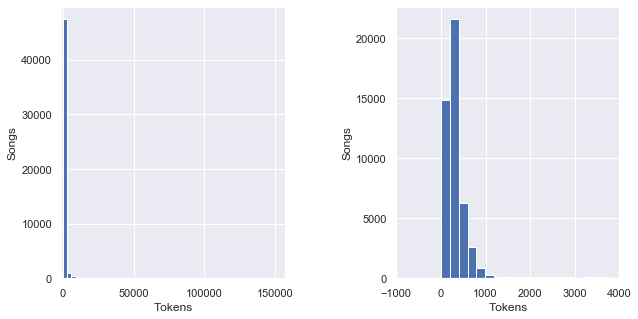

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(lyrics_df.lyrics.apply(lambda text: len(text.split())), bins=50)
ax[0].set_xlim(left=-1000)
ax[0].set_xlabel('Tokens')
ax[0].set_ylabel('Songs')

ax[1].hist(lyrics_df.lyrics.apply(lambda text: len(text.split())), bins=750)
ax[1].set_xlim(left=-1000, right=4000)
ax[1].set_xlabel('Tokens')
ax[1].set_ylabel('Songs')

plt.subplots_adjust(wspace=0.5)
plt.show()

In [22]:
lyrics_df.loc[lyrics_df.lyrics.apply(lambda text: len(text.split())) > 2000, :].shape

(2009, 6)

In [23]:
lyrics_df.loc[lyrics_df.lyrics.apply(lambda text: len(text.split())) < 30, :].shape

(533, 6)

In [24]:
lyrics_df = lyrics_df.loc[
                (lyrics_df.lyrics.apply(lambda text: len(text.split())) < 2000) &
                (lyrics_df.lyrics.apply(lambda text: len(text.split())) > 30)
                ]
lyrics_df.shape

(46357, 6)

#### **3.2.3 Drop duplicates**

Two types of duplicates need to be dropped in order to perform a coherent analysis:
1. Possible duplicates of (artist, song) couples, due to repetitions in *MetroLyrics*' database

In [11]:
lyrics_df.loc[lyrics_df.duplicated(subset=["artist", "song"], keep="first"), :].shape

(676, 6)

In [25]:
lyrics_df.drop_duplicates(subset=["artist", "song"], keep="first", inplace=True)

2. Covers of other songs

In [27]:
lyrics_df.loc[lyrics_df.duplicated(subset=["lyrics"], keep="first"), :].shape

(1836, 6)

In [28]:
lyrics_df.drop_duplicates(subset="lyrics", keep="first", inplace=True)

#### **3.2.4 Manual checks**

Quickly scrolling the dataset I noticed that there are two names for Beyoncé: Beyoncé and Beyoncé-Knowles. It makes sense to rename the latter and drop duplicates

In [15]:
lyrics_df.loc[lyrics_df.artist == "Beyonce Knowles", "artist"] = "Beyoncé"

In [16]:
lyrics_df.loc[lyrics_df.duplicated(subset=["artist", "song"], keep="first"), :].shape

(1, 6)

In [17]:
lyrics_df.drop_duplicates(subset=["artist", "song"], keep="first", inplace=True)

In [18]:
lyrics_df.shape

(43844, 6)

The dataset passed from 50466 instances to 43844 after cleaning.

### **3.3 Annotation**

#### **3.3.1 Genre**

By plotting the distribution of genres across songs it is clear that *Rock*, *Pop* and *Hip-Hop* are the most prevalent genres. Given that there are around 8000 unclassified lyrics, I would like to annotate them in order obtain the full picture and not lose any data point. 

Moreover, I inspected the artists-genre pairs and uncovered some misclassifications that I am going to correct manually.

In [19]:
# list of genres with NaNs as "None" to plot them
genres = [genre if isinstance(genre, float) is False else "None" for genre in lyrics_df.loc[:, "genre"].to_numpy()]

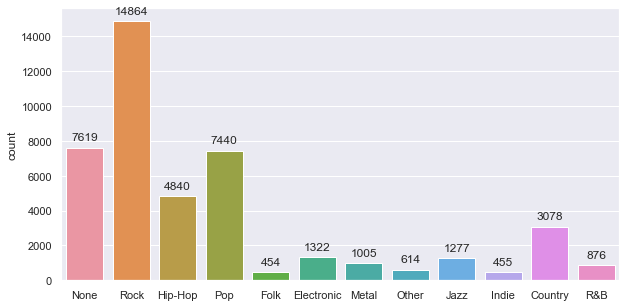

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(genres, ax=ax)
add_value_labels(ax=ax) # from utils.ipynb

#### Correction of misclassifications

In [21]:
corrected_genres = {"Metal": ["Deep Purple", "Iron Maiden", 'Metallica', 'Rammstein'],
                      "Pop": ['Alanis Morissette', 'Gwen Stefani', 'Gary Jules', 'Il Volo', 'Of Monsters And Men', 'Sugar free'], 
                      "Indie": ['Foster The People', 'Gotye', 'HOZIER'],
                      "Folk": ['Joan Baez'], 
                      "Other": ['Soundtrack'], 
                      "R&B": ['Tina Turner', 'Zucchero']
                     }

In [22]:
# update dataset with new genres annotations
for genre, artists in corrected_genres.items():
    for artist in artists:
        lyrics_df.loc[lyrics_df.artist == artist, "genre"] = [genre]*lyrics_df.loc[lyrics_df.artist == artist, "genre"].shape[0]

#### NaNs manual annotation

In [23]:
lyrics_df.loc[lyrics_df.genre.isnull(), "artist"].unique()

array(['6ix9ine', '50 Cent', '2Pac', '30 Seconds to Mars', '6cyclemind',
       '5 Seconds Of Summer', '2Face Idibia', '3 Piece', 'ABBA', 'Adele',
       'A. R. Rahman', 'Annie', 'Aladdin', 'Aizat Amdan',
       'Andrea Bocelli', 'Anthony Brown & Group Therapy',
       'Andrew Lloyd Webber', 'Ariel Rivera', 'Brett Young',
       'The Beatles', 'Bruno Mars', 'Ben&Ben', 'Brian McKnight',
       'Bob Marley', 'Byron Cage', 'Coldplay', 'Children Songs',
       'Céline Dion', 'The Carpenters', 'CupcakKe', 'Christina Perri',
       'Christmas Carols', 'Christmas Song', 'Charlie Puth',
       'Charles Jenkins', 'A Chorus Line', 'Cedarmont Kids', 'Cabaret',
       'Drake', 'Disney', 'Demi Lovato', 'DJ Khaled', 'Dolly Parton',
       'David Bowie', 'Dora The Explorer', 'Dreamgirls', 'Ed Sheeran',
       'Eminem', 'Elton John', 'Ella Fitzgerald', 'Elvis Presley',
       'Eraserheads', 'Earth Wind & Fire', 'Enya', 'Frank Sinatra',
       'Fleetwood Mac', 'Fiona Apple', 'Foo Fighters', 'Fall Out B

In [24]:
# mapping between genre to artists
genre_to_artist = {
    "Hip-Hop": ['6ix9ine', '50 Cent', '2Pac', 'Drake', 'DJ Khaled', 'Eminem', 'Kanye West', 'Lil Wayne', 'Nicki Minaj', 'XXXTENTACION', 'CupcakKe', 'Quavo', 'YoungBoy Never Broke Again', 'YG'], 
    "Rock": ['Green Day', '30 Seconds to Mars', 'Linkin Park', 'The Rolling Stones', 'David Bowie', 'Elton John', 'Elvis Presley', 'U2', 'Eraserheads', 'Hale', 'Fall Out Boy', 'Fleetwood Mac', 'Parokya Ni Edgar', 'Van Morrison', 'Foo Fighters', 'Prince', 'Queen', 'Rivermaya', 'Urban Dub', 'Vashawn Mitchell', 'Valli Frankie'], 
    "Pop": ['Maroon 5', 'Michael Jackson', 'OneRepublic', 'Harry Styles', 'Rihanna', 'One Direction', 'Idina Menzel', 'Jass Manak', 'IV Of Spades', 'Gipsy Kings', 'Fiona Apple', 'Gary Valenciano', 'Morissette Amon', 'Christina Perri', 'zain bhikha', 'Guru Randhawa', 'Ariel Rivera', 'Victorious Cast', '5 Seconds Of Summer', 'Miley Cyrus', 'We Three', 'Yo Yo Honey Singh', 'Yung Raja', 'Yeng Constantino', 'Westlife', 'Sabyan Gambus', 'Regine Velasquez', 'Velasquez Regine', 'Mariah Carey', 'Aizat Amdan', 'Katy Perry', 'Vanessa Hudgens', 'Justin Bieber', 'K. K.', 'Lady GaGa', 'Zac Efron', 'Taylor Swift', 'Oasis', 'Jason Mraz', 'Whitney Houston', 'Ed Sheeran', '6cyclemind', 'Orange And Lemons', 'ABBA', 'Luis Fonsi', 'Adele', 'Andrea Bocelli', 'The Beatles', 'Bruno Mars', 'Coldplay', 'Luciano Pavarotti', 'Céline Dion', 'Martin Nievera', 'The Carpenters', 'Demi Lovato', 'Imagine Dragons'],
    "Other": ['Disney', 'Aladdin', 'Christmas Carols', 'Jesus Christ Superstar', 'Company - Into the Woods', "Gilligan's Island",  'Cabaret', 'VeggieTales', 'A Chorus Line', 'The King And I', 'SpongeBob SquarePants', 'Little Shop Of Horrors', 'Pitch Perfect', 'Miss Saigon', 'RENT', 'South Park', 'Annie', 'LION KING',  '3 Piece', 'Yuvan Shankar Raja', 'Vishal Dadlani', 'Vicente Fernandez', 'Sesame Street', 'Sound Of Music', 'Raffi', 'Music Man', 'Christmas Song', 'Yanni', 'The Yogscast', 'US Marine Corps', 'Tv Theme', 'Scooby Doo Theme Songs', 'My Fair Lady', 'X Factor (UK)', 'X Factor (US)', 'Ran', 'Westside Story', 'Oscar Isaac', 'Quest', 'Wrestling', 'Wizard Of Oz', 'Newsies-Original Broadway Cast', 'Peterpan', 'Simpsons', 'The Phantom of the Opera (Original London Cast)', 'Neha Kakkar', 'Nawab', 'Phineas and Ferb', 'Pokémon', 'Unknown', 'Original Broadway Cast Recording', 'Dora The Explorer', 'Enya', 'Children Songs', 'Monty Python', 'Meryl Streep', 'Grease', 'Happy Birthday', 'Hans Zimmer'],
    "Reggae": ['Bob Marley', 'Ziggy Marley', '2Face Idibia', 'Ub40'],
    "Gospel": ['Lynda Randle', 'Andrew Lloyd Webber', 'Hezekiah Walker', 'Howard Shore', 'Israel', 'Byron Cage', 'Israel Houghton', 'J J Hairston & Youthful Praise', 'Fred Hammond', 'Dreamgirls', 'Hillsong United', 'Hillsong', 'James Weldon Johnson', 'Yolanda Adams', 'Charles Jenkins', 'Kirk Franklin', 'Cedarmont Kids', 'Tasha Cobbs', 'Gaither Vocal Band', 'A. R. Rahman', 'Anthony Brown & Group Therapy'],
    "Jazz": ['Ella Fitzgerald', 'Frank Sinatra'],
    "R&B": ['Earth Wind & Fire', 'Ne-Yo', 'Usher', 'Brian McKnight', 'Charlie Puth', 'India Arie', "The O'Jays", 'Queen Naija', 'Zayn Malik', 'Zack Knight', 'Zhavia Ward'],
    "Country": ['Johnny Cash', 'Brett Young', 'Dolly Parton', 'Garth Brooks', 'Hank Williams', 'Hillary Scott', 'Jimmy Buffett', 'Kenny Chesney', 'Willie Nelson', 'Zac Brown Band'], 
    "Metal": ['Ozzy Osbourne', 'Queens of The Stone Age', 'Quiet riot'], 
    "Indie": ['Ben&Ben', 'Pheobe', 'The Xx'],
    "Folk": ['Irish Rovers', 'Xavier Rudd'],
    "Electronic": ['Oliver', 'WICKED CREW']
}

In [25]:
# update dataset with new genres annotations
for genre in tqdm(genre_to_artist.keys()):
    for artist in genre_to_artist[genre]:
        lyrics_df.loc[lyrics_df.artist == artist, "genre"] = genre

100%|██████████| 13/13 [00:07<00:00,  3.93it/s]


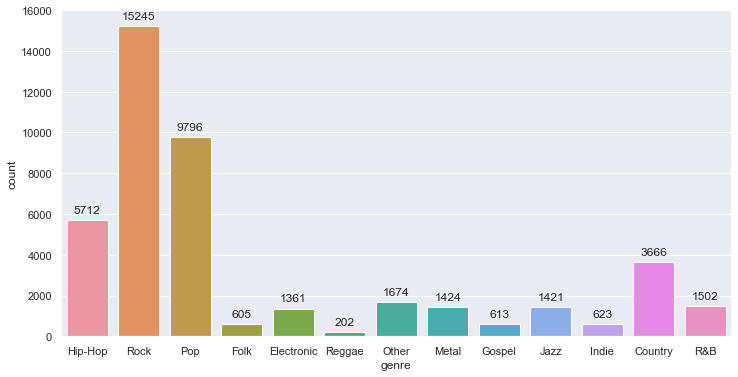

In [27]:
genres_complete = lyrics_df.genre
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(genres_complete, ax=ax)
add_value_labels(ax=ax)

#### **3.3.2 Release date**

Release dates are used to classify each song in different periods in an aggregated way, so that the analysis can focus on linguistic variations across these periods.

Unfortunately, approximately a third of release dates were missing, therefore I filled the NaNs in a coherent way according to each artist, both manually and automatically, dividing the criterion between artists that have no dates at all for their songs and artists that have at least some.

In [29]:
lyrics_df.loc[lyrics_df.release_date.isnull(), :].shape

(16460, 6)

In [29]:
# create "year" column. Month and Day are not useful for the purposes of the analysis
lyrics_df.loc[:, "year"] = None
lyrics_df.loc[lyrics_df.release_date.notnull(), "year"] = \
        lyrics_df.loc[lyrics_df.release_date.notnull(), "release_date"].apply(lambda date: datetime.strptime(date, "%Y-%m-%d").year)

In [30]:
# set to None any year before 1900 and greater than 2020 --> clearly a mistake
lyrics_df = lyrics_df.astype({"year": float})
lyrics_df.loc[(lyrics_df.year < 1900) | (lyrics_df.year > 2020), "year"] = None

#### Artists with no dates at all

There are some artists for which no song has its release date. Since these amount to 74 musicians in total, I decided to annotate them by hand. 

The analysis is concerned, among other things, with the evolution over time of topics, writing styles and genres, where time is divided in multiple periods as explained above. As a consequence, the level of granularity provided by a manual annotation of the year of each song would not result in an increase of information for my purposes. 

Nonetheless, an ideal and coherent annotation would obviously take into account the years of activity of an artist. Therefore I decided to search for them on the web and then label the songs according to a uniform probability over the years of activity of each musician.
In this way, a song that has been released, say, in 1974, could maybe be annotated as 1979, but this would not influence my analysis which takes into account only aggregated periods.

In [32]:
# how many songs for each artist
all_year_nan_artists = []
for artist in lyrics_df.artist.unique():
    artist_df = lyrics_df.loc[(lyrics_df.artist == artist), :]
    artist_df_length = artist_df.loc[:, "year"].shape[0]
    count_year_nans = artist_df.loc[:, "year"].isnull().sum()
    # if n° NaNs equals n° of rows
    if count_year_nans == artist_df_length:
        all_year_nan_artists.append((artist, artist_df_length))
len(all_year_nan_artists)

74

In [33]:
all_year_nan_artists

[('7horse', 1),
 ('A. R. Rahman', 1),
 ('Andrew E', 2),
 ('Ariel Rivera', 5),
 ('Original Cast of "Cats"', 20),
 ('Cedarmont Kids', 8),
 ('Dr. Tumi', 2),
 ('December Avenue', 1),
 ('Edith Piaf', 3),
 ('Fairport Convention', 46),
 ('Frankie Laine', 35),
 ('Frazey Ford', 17),
 ('Gary Valenciano', 16),
 ('Soweto Gospel Choir', 1),
 ('Gipsy Kings', 1),
 ('Glenn Fredly', 1),
 ('Gerry And The Pacemakers', 35),
 ('Gyroscope', 32),
 ('Irish Rovers', 25),
 ('The Irish Descendants', 3),
 ('Imago', 1),
 ('iLe', 1),
 ('Iyeoka', 10),
 ('Johnny Rebel', 2),
 ('JAY-R', 2),
 ('James Weldon Johnson', 2),
 ('Kamikazee', 1),
 ('Luciano Pavarotti', 9),
 ('Lynda Randle', 4),
 ('Martin Nievera', 21),
 ('Mocca', 26),
 ('Nawab', 1),
 ('Neha Kakkar', 1),
 ('Nana Mouskouri', 32),
 ('Opus', 3),
 ('The Phantom of the Opera (Original London Cast)', 1),
 ('Petra', 70),
 ('Quindon Tarver', 2),
 ('Queen Ifrica', 2),
 ('Question Mark & The Mysterians', 2),
 ('Qntal', 3),
 ('Quorthon', 22),
 ('Quincy Punx', 39),
 ('The 

##### Assign year to each song according to a uniform probability over years of activity of artist


In [34]:
artist_years_mapping = {
    '7horse': np.random.choice([year for year in range(2011, 2021)], size=1),
    'A. R. Rahman': np.random.choice([year for year in range(1992, 2021)], size=1),
    'Andrew E': np.random.choice([year for year in range(1985, 2021)], size=2),
    'Ariel Rivera': np.random.choice([year for year in range(1989, 2021)], size=5),
    'Original Cast of "Cats"': 2019*np.ones(shape=20),
    'Cedarmont Kids': np.random.choice([year for year in range(1993, 2000)], size=8),
    'Dr. Tumi': np.random.choice([year for year in range(2010, 2021)], size=2),
    'December Avenue': np.random.choice([year for year in range(2007, 2021)], size=1),
    'Edith Piaf': np.random.choice([year for year in range(1935, 1964)], size=3),
    'Fairport Convention': np.random.choice([year for year in range(1967, 2000)], size=46),
    'Frankie Laine': np.random.choice([year for year in range(1932, 1976)], size=35),
    'Frazey Ford': np.random.choice([year for year in range(2001, 2021)], size=17),
    'Gary Valenciano': np.random.choice([year for year in range(1982, 2021)], size=16),
    'Soweto Gospel Choir': np.random.choice([year for year in range(2005, 2019)], size=1),
    'Gipsy Kings': np.random.choice([year for year in range(1978, 2019)], size=1),
    'Glenn Fredly': np.random.choice([year for year in range(1995, 2021)], size=1),
    'Gerry And The Pacemakers': np.random.choice([year for year in range(1959, 1974)], size=35),
    'Gyroscope': np.random.choice([year for year in range(1997, 2021)], size=32),
    'Irish Rovers': np.random.choice([year for year in range(1967, 2012)], size=25),
    'The Irish Descendants': np.random.choice([year for year in range(1991, 2007)], size=3),
    'Imago': np.random.choice([year for year in range(1997, 2021)], size=1),
    'iLe': np.random.choice([year for year in range(2004, 2021)], size=1),
    'Iyeoka': np.random.choice([year for year in range(1996, 2021)], size=10),
    'Johnny Rebel': np.random.choice([year for year in range(1966, 2003)], size=2),
    'JAY-R': np.random.choice([year for year in range(1997, 2021)], size=2),
    'James Weldon Johnson': np.random.choice([year for year in range(1940, 1960)], size=2),
    'Kamikazee': np.random.choice([year for year in range(2000, 2015)], size=1),
    'Luciano Pavarotti': np.random.choice([year for year in range(1980, 2000)], size=9),
    'Lynda Randle': np.random.choice([year for year in range(2003, 2016)], size=4),
    'Martin Nievera': np.random.choice([year for year in range(1982, 2021)], size=21),
    'Mocca': np.random.choice([year for year in range(1997, 2021)], size=26),
    'Nawab': np.array([2019]),
    'Neha Kakkar': np.random.choice([year for year in range(2006, 2021)], size=1),
    'Nana Mouskouri': np.random.choice([year for year in range(1958, 2008)], size=32),
    'Opus': np.random.choice([year for year in range(1973, 2004)], size=3),
    'The Phantom of the Opera (Original London Cast)': np.array([1988]),
    'Petra': np.random.choice([year for year in range(1973, 2006)], size=70),
    'Quindon Tarver': np.random.choice([year for year in range(1996, 2021)], size=2),
    'Queen Ifrica': np.random.choice([year for year in range(1995, 2021)], size=2),
    'Question Mark & The Mysterians': np.random.choice([year for year in range(1966, 2000)], size=2),
    'Qntal': np.random.choice([year for year in range(1991, 2021)], size=3),
    'Quorthon': np.random.choice([year for year in range(1984, 2004)], size=22),
    'Quincy Punx': np.random.choice([year for year in range(1990, 2021)], size=39),
    'The Quakes': np.random.choice([year for year in range(1986, 2021)], size=1),
    'Reed Foehl': np.random.choice([year for year in range(2004, 2021)], size=1),
    'Sugar free': np.random.choice([year for year in range(2000, 2021)], size=1),
    'Silent Sanctuary': np.random.choice([year for year in range(2001, 2021)], size=1),
    'Songs For Children': np.random.choice([year for year in range(1980, 2021)], size=2),
    'Samsons': np.random.choice([year for year in range(1977, 2002)], size=21),
    'Toni Gonzaga': np.random.choice([year for year in range(2001, 2021)], size=10),
    'Ted Gärdestad': np.random.choice([year for year in range(1972, 1994)], size=6),
    'Typecast': np.random.choice([year for year in range(1999, 2021)], size=32),
    'Urban Dub': np.random.choice([year for year in range(2000, 2021)], size=22),
    'US Marine Corps': np.random.choice([year for year in range(1940, 2021)], size=1),
    'The Undertones': np.random.choice([year for year in range(1974, 2013)], size=26),
    'Velasquez Regine': np.random.choice([year for year in range(1986, 2021)], size=33),
    'Vaya Con Dios': np.random.choice([year for year in range(1986, 2009)], size=45),
    'Valli Frankie': np.random.choice([year for year in range(1953, 2021)], size=2),
    'Chorus of Winnie The Pooh': np.random.choice([year for year in range(2000, 2021)], size=1),
    'Wolfgang': np.random.choice([year for year in range(1992, 2021)], size=10),
    'The Wolfe Tones': np.random.choice([year for year in range(1963, 2021)], size=10),
    'X Factor (UK)': np.random.choice([year for year in range(2010, 2021)], size=4),
    'X-Perience': np.random.choice([year for year in range(1995, 2007)], size=20),
    'Ximena Sarinana': np.random.choice([year for year in range(1994, 2021)], size=10),
    'X-Pose': np.array([2019]),
    'xikidi': np.array([2015]),
    'Xiao Yu': np.random.choice([year for year in range(2003, 2021)], size=1),
    'Xasthur': np.random.choice([year for year in range(1995, 2021)], size=14),
    'Xmal Deutschland': np.random.choice([year for year in range(1980, 1990)], size=3),
    'x factor finalists': np.random.choice([year for year in range(2010, 2021)], size=1),
    'Yngwie Malmsteen': np.random.choice([year for year in range(1978, 2021)], size=67),
    'Yusuf Islam': np.random.choice([year for year in range(1995, 2017)], size=20),
    'Yiruma': np.random.choice([year for year in range(2001, 2021)], size=1),
    'zain bhikha': np.random.choice([year for year in range(1990, 2021)], size=2),
}

As an example of the result, Yusuf Islam (previously known as Cat Stevens) has been musically active (publising albums) under this name from 1995 to 2017. Indeed, after he became muslim in 1977 he changed his name and stopped performing from 1980 to 1995. The labels obtained with the method described above are perfectly coherent with the musical activity of this artist.

In [35]:
lyrics_df.loc[lyrics_df.artist == "Yusuf Islam", :]

,artist,song,album,release_date,genre,lyrics,year
48494,Yusuf Islam,A' Is For Allah,Footsteps in the Light,NaN,Folk,"A' is for Allah, nothing but Allah Ba is the b...",NaN
48495,Yusuf Islam,Thinking 'Bout You,Roadsinger,NaN,Folk,"Islam When I hold her hand, I could fly zilli...",NaN
48496,Yusuf Islam,Heaven/Where True Love Goes,An Other Cup,NaN,Folk,The moment you walked inside my door I knew th...,NaN
48497,Yusuf Islam,Don't Let Me Be Misunderstood,An Other Cup,NaN,Folk,"Baby, do you understand me now Sometimes I fee...",NaN
48498,Yusuf Islam,Roadsinger,Roadsinger,NaN,Folk,"Islam Roadsinger came to town, long cape and ...",NaN
48499,Yusuf Islam,Welcome Home,Roadsinger,NaN,Folk,"Saw a sign on the path ""All seekers this way"" ...",NaN
48500,Yusuf Islam,Maybe There's A World,An Other Cup,NaN,Folk,"I have dreamt of a place and time,where nobody...",NaN
48501,Yusuf Islam,I Think I See The Light,An Other Cup,NaN,Folk,"I used to trust nobody, trusting even less the...",NaN
48502,Yusuf Islam,Everytime I Dream,Roadsinger,NaN,Folk,Islam Every time I dream I keep seeing street...,NaN
48503,Yusuf Islam,Midday,NaN,NaN,Folk,I like to take a walk out in the midday Checki...,NaN


In [36]:
for artist, years in tqdm(artist_years_mapping.items()): 
    lyrics_df.loc[lyrics_df.artist == artist, "year"] = years

100%|██████████| 74/74 [00:00<00:00, 153.67it/s]


In [37]:
lyrics_df.loc[lyrics_df.artist == "Yusuf Islam", :]

,artist,song,album,release_date,genre,lyrics,year
48494,Yusuf Islam,A' Is For Allah,Footsteps in the Light,NaN,Folk,"A' is for Allah, nothing but Allah Ba is the b...",2001.0
48495,Yusuf Islam,Thinking 'Bout You,Roadsinger,NaN,Folk,"Islam When I hold her hand, I could fly zilli...",2013.0
48496,Yusuf Islam,Heaven/Where True Love Goes,An Other Cup,NaN,Folk,The moment you walked inside my door I knew th...,1995.0
48497,Yusuf Islam,Don't Let Me Be Misunderstood,An Other Cup,NaN,Folk,"Baby, do you understand me now Sometimes I fee...",2001.0
48498,Yusuf Islam,Roadsinger,Roadsinger,NaN,Folk,"Islam Roadsinger came to town, long cape and ...",2005.0
48499,Yusuf Islam,Welcome Home,Roadsinger,NaN,Folk,"Saw a sign on the path ""All seekers this way"" ...",1999.0
48500,Yusuf Islam,Maybe There's A World,An Other Cup,NaN,Folk,"I have dreamt of a place and time,where nobody...",2006.0
48501,Yusuf Islam,I Think I See The Light,An Other Cup,NaN,Folk,"I used to trust nobody, trusting even less the...",2016.0
48502,Yusuf Islam,Everytime I Dream,Roadsinger,NaN,Folk,Islam Every time I dream I keep seeing street...,2003.0
48503,Yusuf Islam,Midday,NaN,NaN,Folk,I like to take a walk out in the midday Checki...,1998.0


#### Artists with some years missing

As for artists with some years already annotated by *Genius*, I decided to follow a similar approach but with some modifications. Data from the *Genius* API is indeed highly reliable, therefore it makes sense to do a sort of "informed" labelling which exploits current annotation.

In this sense, the procedure below takes all the songs for each artist and looks at the annotated years, computing the minimum, maximum and mean year to follow this logic: 
- if the mean year is also the median year, we label the songs according to a uniform probability distribution over the years of activity;
- if the number of annotated years preceding the mean year is larger, it is reasonable to assume that the artist was more active before the mean year (since we have more data), therefore we label the songs according to a probability distribution with more mass on the first half of the years of activity;
- conversely, we label the songs according to a probability distribution with more mass on the second half of the years of activity.

In [38]:
example = lyrics_df.loc[lyrics_df.artist == "Elton John", :]

In [39]:
example_index = example.loc[example.year.isnull(), :].index
example_index

Int64Index([10450, 10455, 10462, 10473, 10478, 10489, 10492, 10494, 10499,
            10501, 10505, 10514, 10515, 10520, 10523],
           dtype='int64')

In [40]:
example.loc[example.year.isnull(), :]

,artist,song,album,release_date,genre,lyrics,year
10450,Elton John,Rocket Man,NaN,NaN,Rock,She packed my bags last night pre-flight Zero ...,NaN
10455,Elton John,Can You Feel the Love Tonight,NaN,NaN,Rock,There's a calm surrender To the rush of day Wh...,NaN
10462,Elton John,I Guess That's Why They Call It The Blues,Too Low for Zero,NaN,Rock,Don't wish it away Don't look at it like it's...,NaN
10473,Elton John,Mona Lisas And Mad Hatters,NaN,NaN,Rock,We wanted to do a love song for New York City....,NaN
10478,Elton John,Your Song (Live),NaN,NaN,Rock,It's a little bit funny this feeling inside I'...,NaN
10489,Elton John,Sad Songs (say So Much),Breaking Hearts,NaN,Rock,Guess there are times when we all need to sha...,NaN
10492,Elton John,Blue Eyes,Jump Up!,NaN,Rock,"Blue eyes Baby's got blue eyes Like a deep, b...",NaN
10494,Elton John,Candle In The Wind (Live),NaN,NaN,Rock,Goodbye Norma Jean Though I never knew you at ...,NaN
10499,Elton John,Original Sin,Songs from the West Coast,NaN,Rock,"Oh, it's carnival night And they're stringing...",NaN
10501,Elton John,Blessed,Made in England,NaN,Rock,"Hey you, you're a child in my head You haven'...",NaN


In [41]:
int(example.year.min()), int(example.year.max()), int(example.year.mean())

(1969, 2018, 1981)

In [42]:
for artist in tqdm(lyrics_df.loc[lyrics_df.year.isnull()].artist.unique()):
    artist_df = lyrics_df.loc[lyrics_df.artist == artist, :]
    nans_count = artist_df.loc[artist_df.year.isnull(), :].shape[0]
    min_year, max_year, mean_year = int(artist_df.year.min()), int(artist_df.year.max()), int(artist_df.year.mean())
    years = [year for year in range(min_year, max_year+1)]
    count_first_half = artist_df.loc[(artist_df.year.notnull()) & (artist_df.year < mean_year), :].shape[0]
    count_second_half = artist_df.loc[(artist_df.year.notnull()) & (artist_df.year >= mean_year), :].shape[0]
    if len(years) == 1:
        probabilities = [1]
    elif count_first_half > count_second_half:
        probabilities = [0.75/(len(years)//2) for i in range(len(years)//2)] + [0.25/(len(years) - (len(years)//2)) for i in range(len(years) - (len(years)//2))]
    elif count_first_half < count_second_half:
        probabilities = [0.25/(len(years)//2) for i in range(len(years)//2)] + [0.75/(len(years) - (len(years)//2)) for i in range(len(years) - (len(years)//2))]
    else:
        probabilities = [1/(len(years)) for i in range(len(years))]
    nans_filler = np.random.choice(years, size=nans_count, p=probabilities)
    lyrics_df.loc[(lyrics_df.year.isnull()) & (lyrics_df.artist == artist), "year"] = nans_filler

100%|██████████| 807/807 [00:12<00:00, 65.41it/s]


In [43]:
lyrics_df.loc[example_index, :]

,artist,song,album,release_date,genre,lyrics,year
10450,Elton John,Rocket Man,NaN,NaN,Rock,She packed my bags last night pre-flight Zero ...,1978.0
10455,Elton John,Can You Feel the Love Tonight,NaN,NaN,Rock,There's a calm surrender To the rush of day Wh...,1971.0
10462,Elton John,I Guess That's Why They Call It The Blues,Too Low for Zero,NaN,Rock,Don't wish it away Don't look at it like it's...,1992.0
10473,Elton John,Mona Lisas And Mad Hatters,NaN,NaN,Rock,We wanted to do a love song for New York City....,1998.0
10478,Elton John,Your Song (Live),NaN,NaN,Rock,It's a little bit funny this feeling inside I'...,1988.0
10489,Elton John,Sad Songs (say So Much),Breaking Hearts,NaN,Rock,Guess there are times when we all need to sha...,1980.0
10492,Elton John,Blue Eyes,Jump Up!,NaN,Rock,"Blue eyes Baby's got blue eyes Like a deep, b...",1997.0
10494,Elton John,Candle In The Wind (Live),NaN,NaN,Rock,Goodbye Norma Jean Though I never knew you at ...,1977.0
10499,Elton John,Original Sin,Songs from the West Coast,NaN,Rock,"Oh, it's carnival night And they're stringing...",1981.0
10501,Elton John,Blessed,Made in England,NaN,Rock,"Hey you, you're a child in my head You haven'...",1998.0


#### **3.4 Write cleaned and annotated dataset**

In [49]:
lyrics_df.shape

(43844, 7)

In [50]:
lyrics_df = lyrics_df.astype({"artist": str, "song": str, "album": str, 
                             "release_date": str, "genre": str, "lyrics": str, "year": int})

In [51]:
lyrics_df.to_csv("./data/lyrics_cleaned.csv", index=False)

## **4. Preprocessing**